# Define GRASS GIS environments

In [1]:
## Import libraries needed for setting parameters of operating system 
import os
import sys

In [2]:
#### When working on "GRAZEO-1"
## Define GRASS GIS environment variables
os.environ['GISBASE'] = 'C:\\Program Files\\GRASS GIS 7.3.svn'
os.environ['PATH'] = 'C:\\Program Files\\GRASS GIS 7.3.svn\\lib;C:\\Program Files\\GRASS GIS 7.3.svn\\bin;C:\\Program Files\\GRASS GIS 7.3.svn\\extrabin' + os.pathsep + os.environ['PATH']
os.environ['PATH'] = 'C:\\Program Files\\GRASS GIS 7.3.svn\\etc;C:\\Program Files\\GRASS GIS 7.3.svn\\etc\\python' + os.pathsep + os.environ['PATH']
os.environ['PATH'] = 'C:\\Program Files\\GRASS GIS 7.3.svn\\Python27;C:\\Users\\Stagiaire\\AppData\\Roaming\\GRASS7\\addons\\scripts' + os.pathsep + os.environ['PATH']
os.environ['PATH'] = 'C:\\ProgramData\\Anaconda2\\lib\\site-packages' + os.pathsep + os.environ['PATH']
os.environ['GRASS_PYTHON'] = 'C:\Program Files\GRASS GIS 7.3.svn\extrabin\python.exe'
os.environ['PYTHONPATH'] = 'C:\\Program Files\\GRASS GIS 7.3.svn\\etc\\python'
os.environ['GIS_LOCK'] = '$$'
os.environ['GISRC'] = 'C:\\Users\\Stagiaire\\AppData\\Roaming\\GRASS7\\rc'
os.environ['GDAL_DATA'] = 'C:\\Program Files\\GRASS GIS 7.3.svn\\share\\gdal'

In [3]:
## Define GRASS-Python environment
sys.path.append(os.path.join(os.environ['GISBASE'],'etc','python'))

# Calling GRASS GIS modules

In [4]:


## Import library for temporary files creation 
import tempfile 

## Import Numpy library
import numpy as np

## import math library
import math as ma

## Import Pandas library (View and manipulaiton of tables)
from pandas import Series, DataFrame, read_csv
import pandas as pd
import csv
## Import GRASS GIS Python Scripting Library
import grass.script as gscript

##Import vector package from pygrass library
from grass.pygrass.vector import VectorTopo

## Import Random Forest library
from sklearn.ensemble import RandomForestRegressor

## Import matplotlib library
import matplotlib.pyplot as plt
## Import sqlite3 library
import sqlite3

# Part I

This part is dedicated for applying the simplest approach for the creating a population density map using the dasymetric mapping. The most important issue is to create a weighting. The population will be distributed based on this weighting layer using the GRASS GIS module [v.area.weigh](https://grass.osgeo.org/grass72/manuals/addons/v.area.weigh.html)

## Functions' definition for the first part of the script

All the functions used to execute the first part are defined in this section. Here we create a simple weighting layer for the dasymetry. It can be:
* The proportion of built up areas in each grid
* Or the sum of buildings' hight within each grid


## Function for preparing data

This function is defined to set the tile size (as a user input) and to extract the resolution and the different categories from the Land Cover

In [5]:
def Data_prep(Land_cover):
    tile_size = input("Entrez la taille de la tuile en metre : ")
    info = gscript.raster_info(Land_cover)
    nsres=info.nsres
    ewres=info.ewres  
    L = []
    for cl in (gscript.parse_command('r.category',map= Land_cover)):
        L.append(cl)
    return tile_size, nsres, ewres, L

## Function for creating a weighting layer: binary approach

This function is defined to create a raster containing the proportion of all buildings or selected ones areas in each pixel. A threshold for buildings' hight is set to select buildings which hight is higher than this value
Inputs are:
* The Land Cover layer 
* The nDSM
* The category of the built up areas
* A threshold for the buildings hight (default value is 0)

In [6]:
def weighting_layer(Land_cover, nDSM, building_class, threshold_in_cm=0 ):
    gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
    threshold_in_m = str(threshold_in_cm*(10**(-2)))
    threshold_in_cm = str(threshold_in_cm)
    building_class = str(building_class)
    if (threshold_in_cm == '0'):
        building = 'binary_class_'+str(building_class)
        gscript.run_command('r.mapcalc', expression=building+'=if('+Land_cover+'=='+building_class+',1,0)',overwrite=True)
        proportion='proportion_binary_class_'+str(building_class)
        density='pop_density_binary_class_'+str(building_class)
        somme = 'somme_binary_classs'+str(building_class)
    else:
        building = 'sup_'+threshold_in_cm
        gscript.run_command('r.mapcalc', expression=building+'=if(( '+Land_cover+'=='+building_class+') & ( '+nDSM+'>= '+threshold_in_m+'),1,0 )',overwrite=True)
        proportion ='proportion_sup_'+threshold_in_cm
        density='pop_density_sup_'+threshold_in_cm
        somme = 'somme_sup_'+threshold_in_cm
        
    gscript.run_command('g.region', raster= Land_cover, res=tile_size)
    gscript.run_command('r.resamp.stats',  input=building, output=somme, method='sum',overwrite=True)#Somme
    gscript.run_command('r.mapcalc', expression= proportion+'= ((('+ somme+')*('+str(ewres*nsres)+')  / ('+str(tile_size**2)+'))*100) ', overwrite=True) 
    return building,proportion,density
        


## Function for creating a weighting layer: hight approach

Function that creates a raster whose pixels contain the sum of hight of all buildings or selected ones. Inputs are:
* Binary layer : 1 for built up areas and 0 for non built up
* Land Cover
* nDSM
* A threshold for the selection (0 as default value)

In [7]:
def weighting_layer__hight(building, Land_cover, nDSM, threshold_in_cm=0):
    gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
    threshold_in_cm = str(threshold_in_cm)
    gscript.run_command('r.mapcalc', expression='building_hight=if('+building+'==1,'+nDSM+'   ,0   )',overwrite=True)
    proportion='proportion_hight'+threshold_in_cm
    density='pop_density_hight'+threshold_in_cm
    gscript.run_command('g.region', raster= Land_cover, res=tile_size)
    gscript.run_command('r.resamp.stats',  input='building_hight', output=proportion, method='sum',overwrite=True)
    return proportion, density

    

## Function for redistributing the population 

This function redistributes the population using a weight layer. It uses the GRASS GIS module [v.area.weigh](https://grass.osgeo.org/grass72/manuals/addons/v.area.weigh.html)

In [8]:
def dasymetric_mapping(vectorLayer, proportion, density,feature):
    gscript.run_command('v.area.weigh', vector=vectorLayer, weight=proportion, output=density, column=feature,overwrite=True)


## Function for running the dasymetry with a simple weighting layer

This function runs the dasymetry by choosing the mode of creation of the weighting layer.
* If the bool_hight parameter is set to True, the weighting layer will contain the buildings hight 
* If not, it will be the proportion of built up areas
* For both cases a threshold can be defined (0 as default value)

In [9]:
def main(Land_cover, nDSM, vectorLayer, building_class,feature, bool_hight, threshold_in_cm=0):
 
    weightFunction = weighting_layer(Land_cover, nDSM, building_class, threshold_in_cm )
    building = weightFunction[0]
    if (bool_hight):
        weight_Hight_Function = weighting_layer__hight(building, Land_cover, nDSM, threshold_in_cm) #weighting layer depending on the buildings' height (requires executing weighting_layer function before) 
        proportion = weight_Hight_Function[0] 
        density = weight_Hight_Function [1]
        print(proportion,density)
    else:
        proportion = weightFunction[1]
        density = weightFunction[2]
    dasymetric_mapping(vectorLayer, proportion, density,feature)

# Running the first part

In this section all input variables are set and the functions all called to execute the script.
Inputs are:
* Land Cover layer
* nDSM layer
* The tile size
* The vector layer of the administrative units: Its attribute table must contain the ID of each unit and the census data (For our case study ID='Sect_ID' or 'OBJECTID' and the census column ='Total'

In [10]:
Land_cover = 'LC_coupe'
nDSM = 'nDSM_mosaik_georef_ordre2'
vectorLayer = 'ouaga_population'
Data = Data_prep(Land_cover)
tile_size = Data[0]
nsres = Data[1]
ewres = Data[2]
classes_list = Data[3]
id_admin = input("entrer le nom de la colonne contenant l'id des unités administratives")
gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
main(Land_cover, nDSM, vectorLayer, 11, 'Total',False)


Entrez la taille de la tuile en metre : 100
entrer le nom de la colonne contenant l'id des unitÃ©s administratives'Sect_ID'


# Part II

This part will be dedicated to the second appraoch for creating a population density map using dasymetric mapping. Here the weigting layer is generated by Random Forest. In fact,the model is trained at the administrative units level. Covariates are the proportion of each Land Cover's class and values predicted are the log population density after applying this model to the grid level. We transform the log into population density and we obtain the weighting layer.

## Functions' definition for the second part

In this section, all functions used in the script are defined. This part is dedicated to create a weighting layer estimated by Random Forest and then apply the dasymetry.
These functions might be used in part III.

## Function for calculating the proportion of each class within each grid

This function takes as input:
* A gridded vecor 
* A list of some classes of the Land Cover (If is not set, the proportions of all classes are calculated)

In [11]:
def proportion_class_grid(vectorLayer, liste = []):
    if (len(liste)==0):
        liste = classes_list
    for cl in liste:
        gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
        #add a new column
        gscript.run_command('v.db.addcolumn', map_=vectorLayer, column= "proportion_"+str(cl)+" double precision")
        #call a function which calculate the class's proportion
        proportion = weighting_layer(Land_cover, nDSM, cl)[1]
        #filling the attribute table whith this proportion
        gscript.run_command('v.what.rast', map_=vectorLayer, type='centroid', raster=proportion, column= "proportion_"+str(cl))

## Function for changing the administrative boundaries into a staircase appearence

The purpose here is to make every grid be contained in only one administrative unit

In [12]:
def admin_boundaries(vectorLayer, id_admin):
    gscript.run_command('g.region', raster=Land_cover, res=tile_size)
    gscript.run_command('v.to.rast', input= vectorLayer, type='area', output=vectorLayer+'_rast', use='cat', overwrite=True)
    gscript.run_command('r.to.vect', input=vectorLayer+'_rast', output= vectorLayer+'_rastTovect', type='area', column=id_admin, flags='v',overwrite=True)
    gscript.run_command('v.db.join', map=vectorLayer+'_rastTovect', column='cat',other_table=vectorLayer, other_column='cat')

## Function for calculating the proportion of classes within each administrative unit

In [13]:
def proportion_class_admin(vectorLayer,liste = []):
    if (len(liste)==0):
        liste = classes_list
    for cl in liste:
        gscript.run_command('v.rast.stats', map=vectorLayer,raster='proportion_binary_class_'+str(cl), column_prefix='proportion_'+str(cl), method='average', flags='c')

## 1-Preparing data

In this section, we prepare data and calculate covariates for random forest (at grid and administrative unit level)

### Creating a gridded vector

To create a gridded vector, we need to set the region to the Land Cover's hold and the resolution to the tile size. Then, we create a raster containing random values and we clump it to have a unique value for each grid. Finally we convert it into a vector layer.

In [31]:
gscript.run_command('g.region', raster= Land_cover, res=tile_size)
gscript.mapcalc("empty_grid=rand(0 ,999999999 )", overwrite=True,seed='auto' )
gscript.run_command('r.clump',input='empty_grid',output='empty_grid_Clump',overwrite=True)
gscript.run_command('r.to.vect',input='empty_grid_Clump',output='grid_vector', type='area', overwrite=True)


0

### Covariates' calculation

#### Covariates at grid level

In [16]:
proportion_class_grid('grid_vector')

Now we import the attribute table of the grid vector and we set NULL values,that cause a problem for Random Forest, to 0 

In [22]:
outputfile=tempfile.gettempdir()
#export the attribute table of the gridded vector
gscript.run_command('db.out.ogr', input="grid_vector", output= outputfile+"\\grid_vector.csv" , format='CSV')
df_grid = pd.read_csv(outputfile+"\\grid_vector.csv")
## changing null values to zero
features = df_grid.columns[:]
for i in features:
    for j in range(len(df_grid)):
        if(ma.isnan(df_grid[i].values[j])):
            df_grid[i].values[j] = 0

c:\users\stagia~1\appdata\local\temp


#### Covariates at administrative unit level

In [23]:
admin_boundaries(vectorLayer, id_admin)

In [24]:
proportion_class_admin(vectorLayer+'_rastTovect')

Here we calculate the log population density at administrative unit level. This will be the response variable for the Random Forest model. These steps are followed :
* Add a new column in the attribute table of the administrative units vector called "natural_log_population_density"
* Exoprt the attribute table to a csv file
* Import the csv as a dataframe
* Calculate the log of the population denstiy : log(population/area)
* Export the dataframe to csv
* Imoprt the csv to grass database
* make a juncture between the new table imported and the attribute table

PS : 
* we can read directly the attribute table,as a dataframe, from the datbase but the execution time is almost the same 
* we tried to calculate the log from with SQL request but it didn't work (due to the log )

In [25]:
#add a new column
gscript.run_command('v.db.addcolumn', map_=vectorLayer+'_rastTovect', column= "natural_log_population_density double precision")

0

In [26]:
#exporting the new attribute table
gscript.run_command('db.out.ogr',input=vectorLayer+'_rastTovect', output=outputfile+"\\"+vectorLayer+"_rastTovect.csv",format='CSV',overwrite=True)

0

In [27]:
attr_table = pd.read_csv(outputfile+"\\"+vectorLayer+"_rastTovect.csv")
#filling the log population column
dens = attr_table['natural_log_population_density']
Total = attr_table['Total']
Area = attr_table['Area']
for i in range(len(dens.values)):
    dens.values[i]=np.log(Total.values[i]/Area.values[i])
#export the dataframe to the csv
attr_table.to_csv(path_or_buf=outputfile+"\\"+vectorLayer+"_rastTovect.csv")

In [28]:
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+"\\"+vectorLayer+"_rastTovect.csv", output='csv_table_in', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map=vectorLayer+'_rastTovect', column=id_admin, other_table='csv_table_in', other_column=id_admin)

0

## 2-Creation of the Random Forest model and prediction

The Random Forest model is trained at the administrative units level. Its covariates are the proportions of Land Cover's classes within each administrative unit. The model uses the log population density for its futur prediction.
Here we set the number of trees of the model to 200 and the oob_score to True to be able to print the out of bag error.

In [29]:
### RF
df_admin_natural_log =pd.read_csv(outputfile+"\\"+vectorLayer+"_rastTovect.csv") 
x = df_admin_natural_log.loc[:,'proportion_11_average':'proportion_21_average']
y = df_admin_natural_log['natural_log_population_density']
x_grid = df_grid.loc[:,'proportion_11':'proportion_21']
regressor = RandomForestRegressor(n_estimators = 200, oob_score = True)
regressor.fit(x, y)
prediction = regressor.predict(x_grid)

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 8 

### Covariates' importance study

Here we plot the feature importances using the attribute feauture-importances of the model.

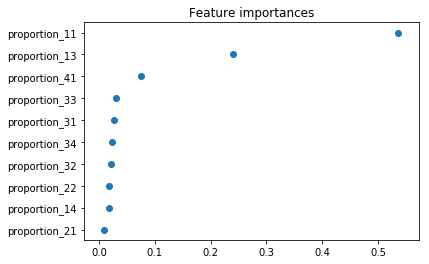

In [25]:
## covariates' importance study
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]
x_axis = importances[indices][::-1]
idx = indices[::-1]
y_axis = range(x.shape[1])
plt.scatter(x_axis,y_axis)
Labels = []
for i in range(x.shape[1]):
    Labels.append(x_grid.columns[idx[i]])
plt.yticks(y_axis, Labels)
plt.title("Feature importances")
plt.show()

## 3-Exploitation of the Random Forest output

In this section, we transform the predicted log population density into population density which will be considered as weight. Then, we export the results, we join them with the attribute table of the gridded vector and create a raster whose pixels contain the value of the predicted weight. Finally we use this weighting layer for the dasymetry as above using the [v.area.weigh](https://grass.osgeo.org/grass72/manuals/addons/v.area.weigh.html) 

In [26]:
# Transform the log population density into population density
df1 = df_grid['cat']
df2 = pd.DataFrame(prediction, columns=['natural_log'])
df_weight = pd.concat((df1,df2), axis=1)
col = df_weight.apply ( lambda row : np.exp(row["natural_log"]), axis = 1 ) 
df_weight ["weight_after_nat_log"] = col

In [27]:
#Export the dataframe to a csv file
df_weight.to_csv(path_or_buf=outputfile+"\\weight.csv")
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
# create a csvt file containing columns types
f = open(outputfile+"\\weight.csvt", 'w')
header_string = '"Integer", "Integer","Real","Real"'
f.write(header_string)
f.close()

In [28]:
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+"\\weight.csv", output='weight_natural_log_table', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map='grid_vector', column='cat', other_table='weight_natural_log_table', other_column='cat_')
#converting the vector layer to a raster one containing the weight generated by RF
gscript.run_command('v.to.rast', input='grid_vector', type='area', output='RFweight_after_natural_log',use='attr', attribute_column='weight_after_nat_log', overwrite=True)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
#assigning 0 value to pixels that are outside the study area
gscript.run_command('r.mapcalc', expression="RFweight_after_natural_log_Bis = if( ouaga_population_rast !=0, RFweight_after_natural_log,0)",overwrite=True)

0

In [29]:
#dasymetric mapping
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
dasymetric_mapping('ouaga_population', 'RFweight_after_natural_log_Bis', 'RF_population_density_after_natural_log','Total')

To refine the result, we can set the weight in areas where it is impossible to find population (like dams, forests...) into 0. Then we use this modified weighting layer for the dasymetry.

In [30]:
## creating a mask for zones where it is impossoble to find population (Lakes, aeroport..)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
gscript.run_command('r.mapcalc',expression="RFweight_after_nat_log_improved = if( proportion_binary_class_11 !=0,RFweight_after_natural_log_Bis,0)", overwrite=True)
dasymetric_mapping('ouaga_population', 'RFweight_after_nat_log_improved', 'RF_population_density_after_nat_log_improved','Total')

Now we delete temporary csv files

In [39]:
os.remove(outputfile+"\\grid_vector.csv")
os.remove(outputfile+"\\"+vectorLayer+"_rastTovect.csv")
os.remove(outputfile+"\\weight.csv")

# Part III

Here we use the same approach as below but we add a new layer. It's a vector one which descibes the morphological aspect of built up areas. The aim of this part is to rasterize this layer, calculate the proportion of each morphological zone at the grid and the administrative units level. Then, launch the Random Forest model as below. 
Please run part preparing data of part II before.

## 1-Preparing data

### preparing data : grid level

Here we rasterize the vector layer of the morphological zones and we calculate the proportion of each category within each grid using the function of the first part. 

In [32]:
#Rasterize morpho layer
gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
Morpho = 'Decoup_morpho'
gscript.run_command('v.to.rast', input=Morpho, output=Morpho+'_rast', use='attr', attribute_column='type',overwrite=True)

0

In [33]:
##Extract morpho layer's classes
List_morpho = []
for cl in (gscript.parse_command('r.category',map= Morpho+'_rast')):
    List_morpho.append(cl)

Here we need to delete all intermediate layers starting with "proportion_binary_class". These are layers for the calculation of the Land Cover's classes. We will recreate them with the proportion of the morphological zones.

In [58]:
for cl in List_morpho:
    gscript.run_command('g.region', raster=Land_cover, nsres=nsres, ewres=ewres)
    #add a new column
    gscript.run_command('v.db.addcolumn', map_='grid_vector', column= "proportion_morpho_"+str(cl)+" double precision")
    #call a function that calculates the class's proportion
    proportion_morpho = weighting_layer(Morpho+'_rast', nDSM, cl)[1]
    #filling the attribute table whith this proportion
    gscript.run_command('v.what.rast', map_='grid_vector', type='centroid', raster=proportion_morpho, column= "proportion_morpho_"+str(cl))

CalledModuleError: Module run None ['v.db.addcolumn', 'column=proportion_morpho_11 double precision', 'map=grid_vector'] ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

In [ ]:
os.remove(outputfile+"\\grid_vector_morpho.csv")

In [37]:
outputfile=tempfile.gettempdir()
##Export the attribute table to a csv file
gscript.run_command('db.out.ogr', input="grid_vector", output= outputfile+"\\grid_vector_morpho.csv" , format='CSV')

0

We set NULL values,which cause a problem for Random Forest, to 0. 

In [38]:
df_grid_morpho = pd.read_csv(outputfile+"\\grid_vector_morpho.csv")
## changing null values to zero
features = df_grid_morpho.columns[:]
for i in features:
    for j in range(len(df_grid_morpho)):
        if(ma.isnan(df_grid_morpho[i].values[j])):
            df_grid_morpho[i].values[j] = 0

### Preparing data: administrative unit level

In [40]:
##Calculating classes'proportions within administrative unit
for cl in List_morpho:
        gscript.run_command('v.rast.stats', map=vectorLayer+'_rastTovect',raster='proportion_binary_class_'+str(cl), column_prefix='proportion_morpho_'+str(cl), method='average', flags='c')

In [49]:
##Export the attribute table to a csv file
gscript.run_command('db.out.ogr', input=vectorLayer+'_rastTovect', output= outputfile+"\\"+vectorLayer+"_rastTovect_morpho.csv" , format='CSV')
df_admin_morpho = pd.read_csv(outputfile+"\\"+vectorLayer+"_rastTovect_morpho.csv")

## 2-Creation of the Random Forest model and prediction

In [54]:

xbis1 = df_admin_morpho.loc[:,'proportion_11_average':'proportion_21_average']
xbis2=df_admin_morpho.loc[:,'proportion_morpho_11_average':'proportion_morpho_21_average']
x = pd.concat((xbis1,xbis2), axis=1)
y = df_admin_morpho['natural_log_population_density']
x_grid1 = df_grid_morpho.loc[:,'proportion_11':'proportion_21']
x_grid2 = df_grid_morpho.loc[:,'proportion_morpho_11':'proportion_morpho_21']
x_grid =  pd.concat((x_grid1,x_grid2), axis=1)

regressor = RandomForestRegressor(n_estimators = 200, oob_score = True)
regressor.fit(x, y)
prediction = regressor.predict(x_grid)

In [56]:
print(x)

    proportion_11_average  proportion_13_average  proportion_14_average  \
0                0.000000              11.538627              19.536898   
1               10.249489               8.518775               8.509683   
2                0.002967              23.366971              11.919604   
3               13.678901               3.335656               2.229031   
4                0.000000               0.000000               0.000000   
5                0.000000               0.000000               0.000000   
6                2.015583              18.099734              27.549633   
7               45.393295              11.272553               0.524559   
8                0.000000               0.000000               0.000000   
9                0.006247               2.105926               0.000000   
10               0.231594               0.000000               0.000000   
11               2.072112               1.531677               0.000000   
12               0.685978

### Covariates' importance study

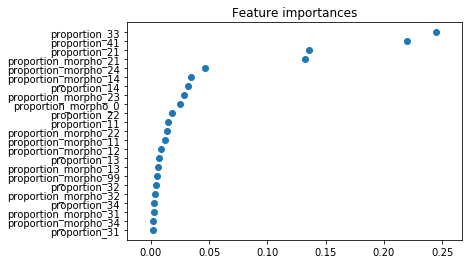

In [55]:
## covariates' importance study
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]
x_axis = importances[indices][::-1]
idx = indices[::-1]
y_axis = range(x.shape[1])
plt.scatter(x_axis,y_axis)
Labels = []
for i in range(x.shape[1]):
    Labels.append(x_grid.columns[idx[i]])
plt.yticks(y_axis, Labels)
plt.title("Feature importances")
plt.show()


## 3-Exploitation of the Random Forest output

In this section, we transform the predicted log population density into population density which will be considered as weight. Then, we export the results, we join them with the attribute table of the gridded vector and create a raster whose pixels contain the value of the predicted weight. Finally we use this weighting layer for the dasymetry as above using the [v.area.weigh](https://grass.osgeo.org/grass72/manuals/addons/v.area.weigh.html) 

In [15]:
df1 = df_grid_morpho['cat']
df2 = pd.DataFrame(prediction, columns=['log_morpho'])
df_weight_morpho = pd.concat((df1,df2), axis=1)

In [16]:
col = df_weight_morpho.apply ( lambda row : np.exp(row["log_morpho"]), axis = 1 ) 
df_weight_morpho ["weight_after_nat_log_morpho"] = col

In [17]:
outputfile=tempfile.gettempdir()
df_weight_morpho.to_csv(path_or_buf=outputfile+"\\weight_natural_log_morpho.csv")
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
# create a csvt file containing columns types
f = open(outputfile+"\\weight_natural_log_morpho.csvt", 'w')
header_string = '"Integer", "Integer","Real","Real"'
f.write(header_string)
f.close()

In [ ]:
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+"\\weight_natural_log_morpho.csv", output='weight_natural_log_morpho_table', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map='grid_vector', column='cat', other_table='weight_natural_log_morpho_table', other_column='cat_')
#converting the vector layer to a raster one containing the weight generated by RF
gscript.run_command('v.to.rast', input='grid_vector', type='area', output='RFweight_after_natural_log_morpho',use='attr', attribute_column='weight_after_nat_log_morpho', overwrite=True)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
#assigning 0 value to pixels that are outside the study area
gscript.run_command('r.mapcalc', expression="RFweight_after_natural_log_morpho_Bis = if( ouaga_population_rast !=0, RFweight_after_natural_log_morpho,0)",overwrite=True)

In [20]:
#dasymetric mapping
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
dasymetric_mapping('ouaga_population', 'RFweight_after_natural_log_morpho_Bis', 'RF_population_density_after_natural_log_morpho','Total')

In [24]:
## creating a mask for zones where it is impossoble to find population (Lakes, aeroport..)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
gscript.run_command('r.mapcalc',expression="RFweight_after_nat_log_morpho_improved = if( proportion_binary_class_11 !=0,RFweight_after_natural_log_morpho_Bis,0)", overwrite=True)
dasymetric_mapping('ouaga_population', 'RFweight_after_nat_log_morpho_improved', 'RF_population_density_after_nat_log_morpho_improved','Total')

In [25]:
#Difference Map
gscript.run_command('r.mapcalc',expression="diff_afterLog_morpho_pourcent = ((RF_population_density_after_nat_log_morpho_improved - RF_population_density_after_nat_log_improved )/RF_population_density_after_nat_log_morpho_improved)*100", overwrite=True)

0

Here we try to modify the weight manually. If:
* The proportion of small size built up - very dense is higher than 80% we increase the weight by 90% 
* The proportion of Large size built up is higher than 80% we decrease the weight by 80% 

We follow the same steps as below to create a new weighting layer and then to apply the dasymetry 

In [249]:
df_weight_morpho = pd.read_csv(outputfile+"\\weight_natural_log_morpho.csv")
small_size_vdense = df_grid_morpho['proportion_morpho_11']
Large_size_vdense = df_grid_morpho['proportion_morpho_31']
Large_size_hdense = df_grid_morpho['proportion_morpho_32']
Large_size_isolated = df_grid_morpho['proportion_morpho_34']

new_weight = df_weight_morpho['weight_after_nat_log_morpho']
for i in range(len(df_grid_morpho )):
    if((small_size_vdense.values[i]) >= 80):
        p = new_weight.values[i]
        new_weight.values[i] = p*1.90
    elif(((Large_size_vdense.values[i]) >= 80) or ((Large_size_hdense.values[i]) >= 80) or ((Large_size_isolated.values[i]) >= 80)):
        p = new_weight.values[i]
        new_weight.values[i] = p*0.20
        
         


In [250]:
df_weight_morpho_bis = pd.concat((df_grid_morpho['cat'],new_weight), axis=1)



In [252]:
df_weight_morpho_bis.to_csv(path_or_buf=outputfile+"\\weight_natural_log_morpho2.csv")


In [253]:
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+"\\weight_natural_log_morpho2.csv", output='weight_natural_log_morpho_table', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map='grid_vector', column='cat', other_table='weight_natural_log_morpho_table', other_column='cat_')


0

In [254]:
#converting the vector layer to a raster one containing the weight generated by RF
gscript.run_command('v.to.rast', input='grid_vector', type='area', output='RFweight_improved_morpho',use='attr', attribute_column='weight_after_nat_log_morpho', overwrite=True)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
#assigning 0 value to pixels that are outside the study area
gscript.run_command('r.mapcalc', expression="RFweight_improved_morpho_Bis = if( ouaga_population_rast !=0, RFweight_improved_morpho,0)",overwrite=True)

0

In [255]:
#dasymetric mapping
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
dasymetric_mapping('ouaga_population', 'RFweight_improved_morpho_Bis', 'RF_population_density_morpho_weight_improved','Total')
## creating a mask for zones where it is impossoble to find population (Lakes, aeroport..)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
gscript.run_command('r.mapcalc',expression="RFweight_improved_morpho_Bis_2 = if( proportion_binary_class_11 !=0,RFweight_improved_morpho_Bis,0)", overwrite=True)
dasymetric_mapping('ouaga_population', 'RFweight_improved_morpho_Bis_2', 'RF_population_density_morpho_weight_improved_bis','Total')

In [ ]:
#removing intermediate csv files

os.remove(outputfile+"\\grid_vector_morpho.csv")
os.remove(outputfile+"\\"+vectorLayer+"_rastTovect_morpho.csv")
os.remove(outputfile+"\\weight_natural_log_morpho.csv")
os.remove(outputfile+"\\weight_natural_log_morpho2.csv")

# Part IV : the validation

Here we aggregate the administrative unit two by two (sometimes thre is the total number of the administrative units is odd) and we follow these steps:
* Create a weighting layer at this level with Random Forest (trained with the aggregated administrative units)
* Apply the dasymetry
* Disaggregate administrative units 
* Compare the population within each administrative unit with the census data

## Data preparation

We add a new column to be used for merging boundaries

In [29]:
#add a new column
gscript.run_command('v.db.addcolumn', map_=vectorLayer+'_rastTovect', column= "attr_for_merging integer")

0

Now, you have to fill this column manually. Every two (or three) administrative units have to be filled by the same value.

Then, we run [v.dissolve](https://grass.osgeo.org/grass72/manuals/v.dissolve.html) to aggregate them.

In [ ]:
gscript.run_command('v.dissolve', input=vectorLayer+'_rastTovect', column='attr_for_merging', output=vectorLayer+'_dissolved', , overwrite=True)

[v.dissolve](https://grass.osgeo.org/grass72/manuals/v.dissolve.html) dont generate an attribute table. So we need to add one and connect it to the dissolved layer

In [ ]:
gscript.run_command('v.db.addtable', map=vectorLayer+'_dissolved')

At this stage we need to calculate the new population and area inside each aggregated unit.That will be the sum of their native units values. For that we:
* Access to the attribute table of the dissaggregated units via the database
* Make an SQL request to calcule the sum of population and area (using GROUP BY att_for_merging)
* Export the dataframe into a csv file
* Import the csv to GRASS GIS database
* Make a juncture between this table and the attribute table of the aggregated units

In [1]:
## Access to GRASS database
sqlpath = gscript.read_command("db.databases", driver="sqlite").replace('\r\n', '')
sqlpath = sqlpath.replace('/','\\')
con = sqlite3.connect(sqlpath)
sqlstat="SELECT SUM(Total),SUM(Area),attr_for_merging FROM "+vectorLayer+"_rastTovect GROUP BY attr_for_merging;"
df = pd.read_sql_query(sqlstat, con)
con.close()

NameError: name 'gscript' is not defined

In [45]:
outputfile=tempfile.gettempdir()
df.to_csv(outputfile+"\\sum.csv")
# create a csvt file containing columns types
f = open(outputfile+"\\sum.csvt", 'w')
header_string = '"Integer","Real","Real","Integer"'
f.write(header_string)
f.close()

In [46]:
# import the csv to database 
gscript.run_command('db.in.ogr', input=outputfile+"\\sum.csv", output='sum_table', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map=vectorLayer+'_dissolved', column='cat', other_table='sum_table', other_column='attr_for_merging')

0

## Random Forest at the aggregated units level

This part is dedicated to create a weighting layer with Random Forest model trained at the aggregated units level. The process is the same as above. The only difference is that the model was trained with 55 units and now with 27.

In [51]:
proportion_class_admin(vectorLayer+'_dissolved')

In [61]:
#add a new column
gscript.run_command('v.db.addcolumn', map_='ouaga_population_dissolved', column= "natural_log_population_density double precision")

0

In [ ]:
outputfile=tempfile.gettempdir()

In [62]:
#exporting the new attribute table
gscript.run_command('db.out.ogr',input='ouaga_population_dissolved', output=outputfile+'\\admin_table_validation_calc_log.csv',format='CSV',overwrite=True)

0

In [66]:
attr_table = pd.read_csv(outputfile+'\\admin_table_validation_calc_log.csv')
#filling the log population column
dens = attr_table['natural_log_population_density']
Total = attr_table['Total_population']
Area = attr_table['Total_Area']
for i in range(len(dens.values)):
    dens.values[i]=np.log(Total.values[i]/Area.values[i])
#export the dataframe to the csv
attr_table.to_csv(path_or_buf=outputfile+'\\admin_table_validation_calc_log.csv')

In [ ]:
df_admin_natural_log =pd.read_csv(outputfile+'\\admin_table_validation_calc_log.csv')
df_admin_natural_log.drop_duplicates(inplace=True)
gscript.run_command('db.out.ogr', input="grid_vector", output= outputfile+'\\grid.csv' , format='CSV')
df_grid = pd.read_csv(outputfile+'\\grid.csv')

In [75]:
## changing null values to zero
features = df_grid.columns[:]
for i in features:
    for j in range(len(df_grid)):
        if(ma.isnan(df_grid[i].values[j])):
            df_grid[i].values[j] = 0
            

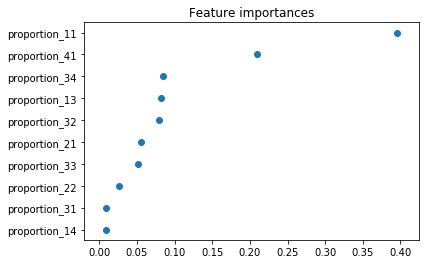

In [76]:
### RF

x = df_admin_natural_log.loc[:,'proportion_11_average':'proportion_21_average']
y = df_admin_natural_log['natural_log_population_density']
x_grid = df_grid.loc[:,'proportion_11':'proportion_21']
regressor = RandomForestRegressor(n_estimators = 200, oob_score = True)
regressor.fit(x, y)
prediction = regressor.predict(x_grid)
## covariates' importance study
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]
x_axis = importances[indices][::-1]
idx = indices[::-1]
y_axis = range(x.shape[1])
plt.scatter(x_axis,y_axis)
Labels = []
for i in range(x.shape[1]):
    Labels.append(x_grid.columns[idx[i]])
plt.yticks(y_axis, Labels)
plt.title("Feature importances")
plt.show()

In [77]:
df1 = df_grid['cat']
df2 = pd.DataFrame(prediction, columns=['log_morpho'])
df_weight = pd.concat((df1,df2), axis=1)

col = df_weight.apply ( lambda row : np.exp(row["log_morpho"]), axis = 1 ) 
df_weight ["weight_after_nat_log"] = col
df_weight.to_csv(path_or_buf=outputfile+"\\grid_weight.csv")
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
# create a csvt file containing columns types
f = open(outputfile+"\\grid_weight.csvt", 'w')
header_string = '"Integer", "Integer","Real","Real"'
f.write(header_string)
f.close()
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+"\\grid_weight.csv", output='weight_natural_log_morpho_table', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map='grid_vector', column='cat', other_table='weight_natural_log_morpho_table', other_column='cat_')


CalledModuleError: Module run None ['v.to.rast', '--o', 'output=weight_dissolved', 'use=attr', 'type=area', 'attribute_column=weight_after_nat_log_morpho', 'input=grid_vector'] ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

In [79]:
#converting the vector layer to a raster one containing the weight generated by RF
gscript.run_command('v.to.rast', input='grid_vector', type='area', output='weight_dissolved',use='attr', attribute_column='weight_after_nat_log', overwrite=True)
gscript.run_command('g.region', raster=Land_cover, res=tile_size)
#assigning 0 value to pixels that are outside the study area
gscript.run_command('r.mapcalc', expression="weight_dissolved = if( ouaga_population_rast !=0, weight_dissolved,0)",overwrite=True)

0

In [83]:
# Dasymetry : only LC
gscript.run_command('g.region', raster= Land_cover, res=tile_size)
dasymetric_mapping('ouaga_population_dissolved', 'weight_dissolved', 'pop_density_dissolved','Total_population')

Now, we have a population density map which is created with a Random Forest model trained with aggregated administrative units. These steps are then followed:
* population is calculated inside each disaggregated administrative unit and compared to the census data
* the %error is calculated (difference between predicted and observed data in pourcent)
* the attribute table of disaggregated units is filled with these errors
* the Root Mean Square Error (RMSE) is calculated


In [101]:
gscript.run_command('g.region', raster= Land_cover, res=tile_size)
gscript.run_command('v.rast.stats', map='ouaga_population_rastTovect', raster='pop_density_dissolved', column_prefix='Total_validation_dissolved', method='sum')
##Export the attribute table to a csv file
gscript.run_command('db.out.ogr', input='ouaga_population_rastTovect', output= outputfile+'\\validation.csv' , format='CSV')
df_admin_new_Total = pd.read_csv( outputfile+'\\validation.csv') 
Total = df_admin_new_Total.loc[:,'Total']
new_Total = df_admin_new_Total.loc[:,'Total_validation_dissolved_sum']

In [102]:

error_list = []
for i in range(len(Total.values)):
    error = ((new_Total.values[i] - Total.values[i])/ Total.values[i])*100
    error_list.append(error)
df1 = df_admin_new_Total['cat']
df2 = pd.DataFrame(error_list, columns=['error'])
df_error = pd.concat((df1,df2), axis=1)
df_error.to_csv(path_or_buf= outputfile+'\\error.csv') 
# create a csvt file containing columns types
f = open(outputfile+'\\error.csvt', 'w')
header_string = '"Integer", "Integer","Real"'
f.write(header_string)
f.close()
#importing the csv to the database
gscript.run_command('db.in.ogr', input=outputfile+'\\error.csv', output='error_table_in', overwrite=True)
# join the two tables
gscript.run_command('v.db.join', map=vectorLayer+'_rastTovect', column='cat', other_table='error_table_in', other_column='cat_')


0

In [105]:
df_admin_new_Total = pd.read_csv(outputfile+'\\validation.csv')
predicted = df_admin_new_Total.loc[:,'Total_validation_dissolved_sum']
observed = df_admin_new_Total.loc[:,'Total']
s = 0
somme = 0
n = len(observed.values)
for i in range(n):
    somme += observed.values[i]
    s+=((predicted.values[i]) -(observed.values[i])) **2
rmse = np.sqrt(s/n)
rmse_pourcent = (rmse / (somme/n))*100
# R²
corr = np.corrcoef(Observations,Predictions)
r_squared = corr**2
print(rmse,rmse_pourcent,r_squared[0,1])
# Plot
fig, ax = plt.subplots()
ax.scatter(observed, predicted)
ax.plot([observed.min(), observed.max()], [predicted.min(), predicted.max()], 'k--', lw=4)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()

(7572.0695462457334, 21.74632264860923, 1915102)


In [ ]:
# deleting intermediate files
os.remove(outputfile+'\\validation.csv')
os.remove(outputfile+'\\error.csvt')
os.remove(outputfile+'\\error.csv')
os.remove(outputfile+"\\grid_weight.csvt")
os.remove(outputfile+"\\grid_weight.csv")
os.remove(outputfile+'\\grid.csv')
os.remove(outputfile+'\\admin_table_validation_calc_log.csv')